# IMPORTS

In [13]:
import pandas as pd
import seaborn as sns
from mplsoccer.pitch import Pitch, VerticalPitch
import matplotlib.pyplot as plt
from statsbombpy import sb
from pandas import json_normalize
import numpy as np
import requests
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import gaussian_kde
import matplotlib.ticker as ticker
from scipy.optimize import differential_evolution

# DATA COLLECTION CODE

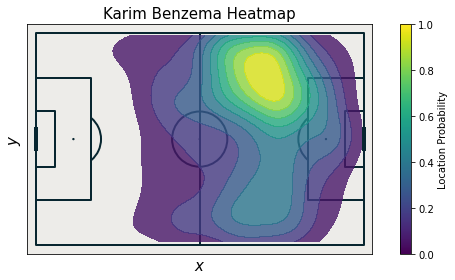

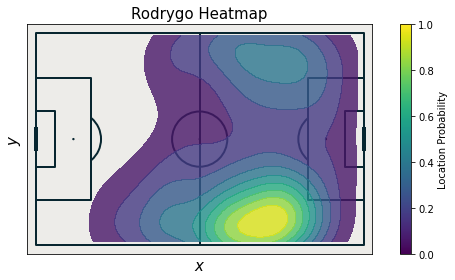

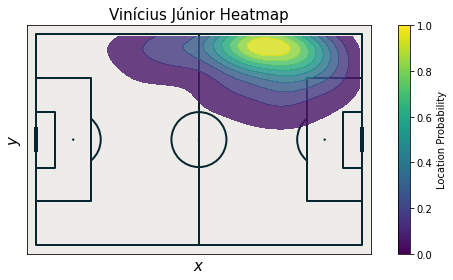

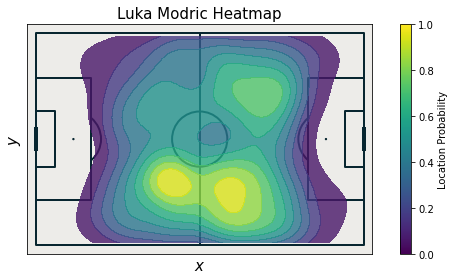

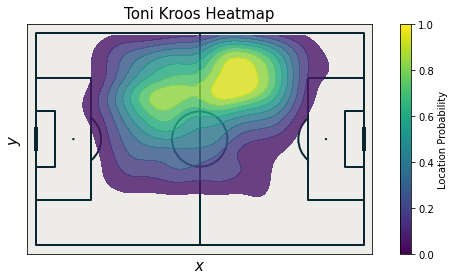

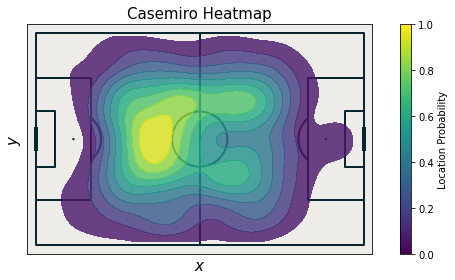

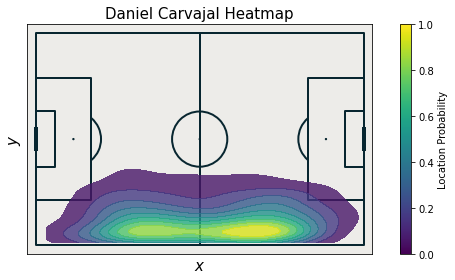

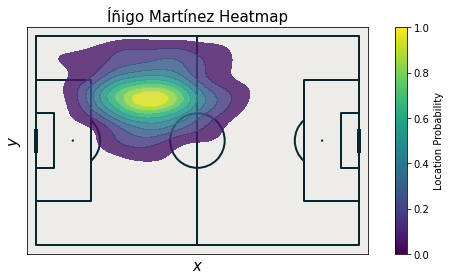

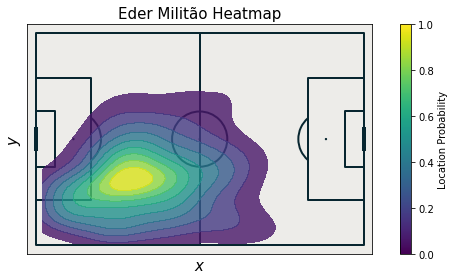

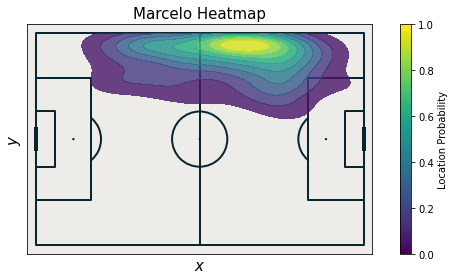

In [140]:
# Read data
data = pd.read_csv("WalkthroughLaLiga.csv")

# Create an empty dictionary to store probabilities for each player
player_probs = {}

# Define the player names
Real_Madrid = [
    "Karim Benzema",
    "Rodrygo",
    "Vinícius Júnior",
    "Luka Modric",
    "Toni Kroos",
    "Casemiro",
    "Daniel Carvajal",
    "Íñigo Martínez",
    "Eder Militão",
    "Marcelo"
]

# Create pitch object with 120 x 80 dimensions
pitch = Pitch(pitch_type='opta', pitch_color='#edece9', axis=True, label=False, line_color='#082630', tick=False)

# Initialize a 3D array to store probabilities for each player (10 players x 120 x 80)
probability_matrix = np.zeros((len(Real_Madrid), 120, 80))

# Plot KDE heat maps and contour plots for selected players
for i, player in enumerate(Real_Madrid):
    # Filter dataframe to only include passes received by the selected player
    player_data = data[data['receiver'] == player]
    
    # Calculate KDE
    kde = gaussian_kde(np.vstack([player_data.end_x, player_data.end_y]))
    
    # Evaluate KDE probabilities at each x, y coordinate
    x_grid, y_grid = np.mgrid[
        min(player_data.end_x):max(player_data.end_x):120j,
        min(player_data.end_y):max(player_data.end_y):80j
    ]
    positions = np.vstack([x_grid.ravel(), y_grid.ravel()])
    prob = kde(positions).reshape(x_grid.shape)
    prob = prob / np.max(prob)  # normalize
    
    # Store probability matrix in the 3D array
    probability_matrix[i] = prob
    
    # Plot KDE heat map
    fig, ax = pitch.draw(figsize=(8, 4))
    
    # Overlay contour plot directly on the pitch
    ax.contourf(x_grid, y_grid, prob, cmap='viridis', alpha=.8, locator=ticker.MaxNLocator(prune='lower'))
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap='viridis')
    sm.set_array([])  # Set dummy array to ensure the colorbar knows the range of values
    colorbar = plt.colorbar(sm, ax=ax)
    colorbar.set_label('Location Probability')

    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title(f'{player} Heatmap', fontsize=15)
    
    plt.show()

# OPTIMIZED WITH NO CONSTRAINTS (CONTROL GROUP)

Optimized position for Karim Benzema: [82.9380159  69.06644018]
Optimized position for Rodrygo: [74.19644606  8.72427258]
Optimized position for Vinícius Júnior: [96.24726389 76.43886357]
Optimized position for Luka Modric: [52.358706  24.4669034]
Optimized position for Toni Kroos: [69.44472236 61.71135161]
Optimized position for Casemiro: [42.09368315 36.98898609]
Optimized position for Daniel Carvajal: [50.53182018  4.5599553 ]
Optimized position for Íñigo Martínez: [42.11857101 56.53408659]
Optimized position for Eder Militão: [32.59336351 22.36780864]
Optimized position for Marcelo: [77.08007419 74.2795966 ]


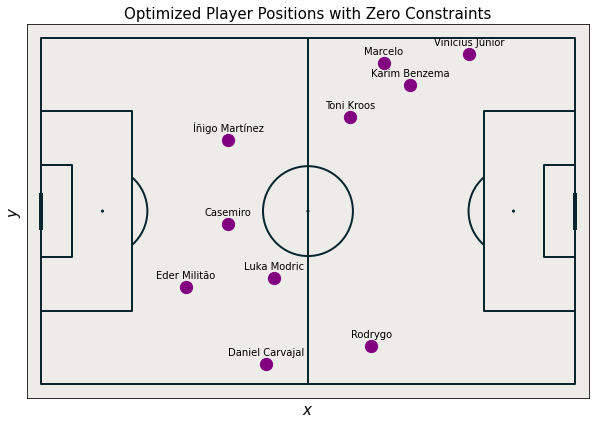

In [141]:
iteration_count = 0

# Callback function to track optimization iterations
def iteration_callback(xk, convergence):
    global iteration_count
    iteration_count += 1

team_weight = 0.7  # Adjust this value between 0 and 1 to balance individual and team probabilities

# Objective function to minimize
def objective(x, probability_matrix, player_idx):
    # x is a 2-element array with [x_coordinate, y_coordinate]
    x_idx = int(np.clip(x[0], 0, 119))
    y_idx = int(np.clip(x[1], 0, 79))

    # Avoid division by zero by adding a small constant
    probability_penalty = 1 / (probability_matrix[player_idx, x_idx, y_idx] + 1e-10)

    # Calculate the sum of individual player probabilities
    team_probability = 0
    for i in range(len(Real_Madrid)):
        team_probability += 1 / (probability_matrix[i, int(optimized_positions[i, 0]), int(optimized_positions[i, 1])] + 1e-10)

    # Combine individual player probability, clustering penalty, and team probability
    objective_value = (1 - team_weight) * probability_penalty + team_weight * team_probability

    return objective_value

# Optimization function for a single player
def optimize_player(player_idx):
    bounds = [(0, 119), (0, 79)]  # Bounds for x and y coordinates
    result = differential_evolution(objective, bounds, args=(probability_matrix, player_idx), strategy='best1bin',
                                   popsize=15, tol=1e-4, mutation=(0.5, 1), recombination=0.7,
                                   seed=42, callback=iteration_callback)
    return result.x

# Optimize positions for all players
optimized_positions = np.zeros((len(Real_Madrid), 2))

for i, player in enumerate(Real_Madrid):
    optimized_positions[i] = optimize_player(i)
    print(f"Optimized position for {player}: {optimized_positions[i]}")

# Scale optimized positions to fit the 100x100 pitch dimensions
optimized_positions_scaled = np.zeros_like(optimized_positions)
optimized_positions_scaled[:, 0] = optimized_positions[:, 0] * (100 / 120)
optimized_positions_scaled[:, 1] = optimized_positions[:, 1] * (100 / 80)

# Plot the optimized positions and save the figure
fig, ax = pitch.draw(figsize=(10, 6))  

# Plot each player's optimized position
for i, player in enumerate(Real_Madrid):
    ax.scatter(optimized_positions_scaled[i][0], optimized_positions_scaled[i][1], color='purple', s=150, label='_nolegend_')
    ax.text(optimized_positions_scaled[i][0], optimized_positions_scaled[i][1] + 2, player, fontsize=10, ha='center', va='bottom')

ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)
ax.set_title('Optimized Player Positions with Zero Constraints', fontsize=15)

# Save the figure
plt.savefig("optimized_positions_with_names.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# OPTIMIZED WHILE PREVENTING CLUSTERS

Optimized position for Karim Benzema: [82.9380159  69.06644018]
Optimized position for Rodrygo: [74.19644606  8.72427258]
Optimized position for Vinícius Júnior: [96.24726389 76.43886357]
Optimized position for Luka Modric: [52.358706  24.4669034]
Optimized position for Toni Kroos: [69.44472236 61.71135161]
Optimized position for Casemiro: [42.09368315 36.98898609]
Optimized position for Daniel Carvajal: [50.53182018  4.5599553 ]
Optimized position for Íñigo Martínez: [42.11857101 56.53408659]
Optimized position for Eder Militão: [32.59336351 22.36780864]
Optimized position for Marcelo: [77.08007419 74.2795966 ]


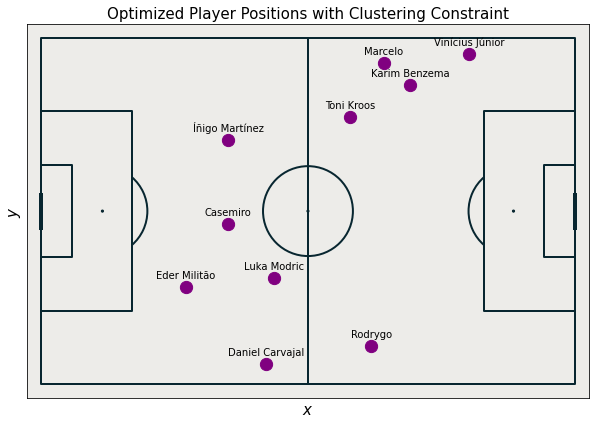

In [148]:
iteration_count = 0

# Callback function to track optimization iterations
def iteration_callback(xk, convergence):
    global iteration_count
    iteration_count += 1

# Define the minimum distance threshold and team weight
min_distance = 0  # Minimum desired distance between players (adjust as needed)
team_weight = 0.7  # Adjust this value between 0 and 1 to balance individual and team probabilities

# Objective function to minimize
def objective(x, probability_matrix, player_idx):
    # x is a 2-element array with [x_coordinate, y_coordinate]
    x_idx = int(np.clip(x[0], 0, 119))
    y_idx = int(np.clip(x[1], 0, 79))

    # Avoid division by zero by adding a small constant
    probability_penalty = 1 / (probability_matrix[player_idx, x_idx, y_idx] + 1e-10)

    # Initialize clustering penalty
    clustering_penalty = 0

    # Calculate distance between the current player and all other players
    for other_idx, other_position in enumerate(optimized_positions):
        if other_idx != player_idx:
            distance = np.linalg.norm(x - other_position)
            if distance < min_distance:
                clustering_penalty += (min_distance - distance) ** 2

    # Calculate the sum of individual player probabilities
    team_probability = 0
    for i in range(len(Real_Madrid)):
        team_probability += 1 / (probability_matrix[i, int(optimized_positions[i, 0]), int(optimized_positions[i, 1])] + 1e-10)

    # Combine individual player probability, clustering penalty, and team probability
    objective_value = (1 - team_weight) * probability_penalty + team_weight * team_probability + clustering_penalty

    return objective_value

# Optimization function for a single player
def optimize_player(player_idx):
    bounds = [(0, 119), (0, 79)]  # Bounds for x and y coordinates
    result = differential_evolution(objective, bounds, args=(probability_matrix, player_idx), strategy='best1bin',
                                    popsize=15, tol=1e-4, mutation=(0.5, 1), recombination=0.7,
                                    seed=42, callback=iteration_callback)
    return result.x

# Optimize positions for all players
optimized_positions = np.zeros((len(Real_Madrid), 2))
for i, player in enumerate(Real_Madrid):
    optimized_positions[i] = optimize_player(i)
    print(f"Optimized position for {player}: {optimized_positions[i]}")

# Scale optimized positions to fit the 100x100 pitch dimensions
optimized_positions_scaled = np.zeros_like(optimized_positions)
optimized_positions_scaled[:, 0] = optimized_positions[:, 0] * (100 / 120)
optimized_positions_scaled[:, 1] = optimized_positions[:, 1] * (100 / 80)

# Plot the optimized positions and save the figure
fig, ax = pitch.draw(figsize=(10, 6))

# Plot each player's optimized position
for i, player in enumerate(Real_Madrid):
    ax.scatter(optimized_positions_scaled[i][0], optimized_positions_scaled[i][1], color='purple', s=150, label='_nolegend_')
    ax.text(optimized_positions_scaled[i][0], optimized_positions_scaled[i][1] + 2, player, fontsize=10, ha='center', va='bottom')

ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)
ax.set_title('Optimized Player Positions with Clustering Constraint', fontsize=15)

# Save the figure
plt.savefig("optimized_positions_with_names.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# ADDING OPPOSING TEAM: BALL IN CORNER

Optimized position for Karim Benzema: [83.4364078  53.97063253]
Optimized position for Rodrygo: [78.11618565 40.94612778]
Optimized position for Vinícius Júnior: [88.29316059 68.0344683 ]
Optimized position for Luka Modric: [93.47596121 21.22299136]
Optimized position for Toni Kroos: [52.76819749 43.40686208]
Optimized position for Casemiro: [88.29316059 57.41628291]
Optimized position for Daniel Carvajal: [45.11404434 44.63206525]
Optimized position for Íñigo Martínez: [46.12791736 66.33869754]
Optimized position for Eder Militão: [52.358706  24.4669034]
Optimized position for Marcelo: [42.11857101 56.53408659]


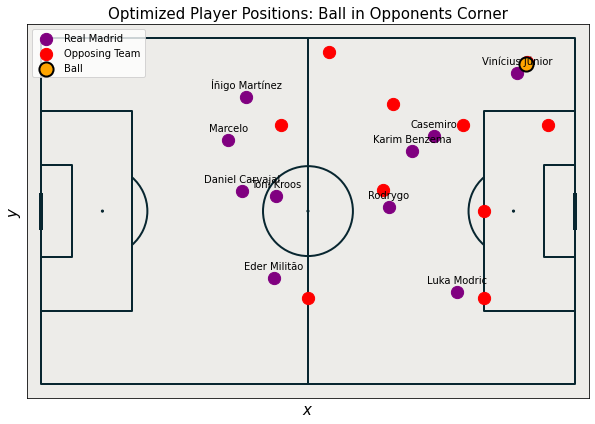

In [145]:
# Define opposing players and their positions (scenario is in the back corner)
opposing_team = ["Opponent " + str(i) for i in range(10)]
opposing_positions = np.array([
    [115, 60], [100, 40],  # Center-backs
    [110, 75], [100, 20],  # Full-backs
    [77, 45], [95, 60], [80, 65],  # Midfielders
    [65, 77], [60, 20],  # Wingers
    [55, 60]  # Striker
])

# Ball position in the back corner for this example
ball_position = np.array([109, 74])

# Define the minimum distance threshold and team weight
min_distance = 5  # Minimum desired distance between players (adjust as needed)
team_weight = 0.5  # Adjust this value between 0 and 1 to balance individual and team probabilities
guard_penalty_weight = 25  # Weight for the guarding position penalty
offside_threshold = 50  # Threshold for pushing the defensive line up

# Objective function to minimize
def objective(x, probability_matrix, player_idx, opposing_positions, ball_position, goal_position):
    # x is a 2-element array with [x_coordinate, y_coordinate]
    x_idx = int(np.clip(x[0], 0, 119))
    y_idx = int(np.clip(x[1], 0, 79))

    # Avoid division by zero by adding a small constant
    probability_penalty = 1 / (probability_matrix[player_idx, x_idx, y_idx] + 1e-10)

    # Initialize clustering penalty
    clustering_penalty = 0

    # Calculate distance between the current player and all other players
    for other_idx, other_position in enumerate(optimized_positions):
        if other_idx != player_idx:
            distance = np.linalg.norm(x - other_position)
            if distance < min_distance:
                clustering_penalty += (min_distance - distance) ** 2

    # Calculate the sum of individual player probabilities
    team_probability = 0
    for i in range(len(Real_Madrid)):
        team_probability += 1 / (probability_matrix[i, int(optimized_positions[i, 0]), int(optimized_positions[i, 1])] + 1e-10)

    # Calculate guard penalty
    guard_penalty = 0
    for opp_idx, opp_position in enumerate(opposing_positions):
        if opp_idx == player_idx:
            distance_to_opp = np.linalg.norm(x - opp_position)
            goal_distance = np.linalg.norm(goal_position - opp_position)
            projected_x = (goal_position[0] - opp_position[0]) * (distance_to_opp / goal_distance) + opp_position[0]
            projected_y = (goal_position[1] - opp_position[1]) * (distance_to_opp / goal_distance) + opp_position[1]
            guard_penalty = np.linalg.norm([projected_x, projected_y] - x) * guard_penalty_weight

    # Offside constraint: push defensive line up if the ball is far up the field
    offside_penalty = 0
    if ball_position[0] > offside_threshold:
        offside_penalty = (x[0] - offside_threshold) ** 2 if x[0] < offside_threshold else 0

    # Combine individual player probability, clustering penalty, guard penalty, and team probability
    objective_value = (1 - team_weight) * probability_penalty + team_weight * team_probability + clustering_penalty + guard_penalty + offside_penalty

    return objective_value

# Optimization function for a single player
def optimize_player(player_idx):
    bounds = [(0, 119), (0, 79)]  # Bounds for x and y coordinates
    result = differential_evolution(objective, bounds, args=(probability_matrix, player_idx, opposing_positions, ball_position, goal_position), strategy='best1bin',
                                    popsize=15, tol=1e-4, mutation=(0.5, 1), recombination=0.7,
                                    seed=42, callback=iteration_callback)
    return result.x

# Define the goal position (center of the goal line)
goal_position = np.array([0, 40])

# Optimize positions for all players
optimized_positions = np.zeros((len(Real_Madrid), 2))
for i, player in enumerate(Real_Madrid):
    optimized_positions[i] = optimize_player(i)
    print(f"Optimized position for {player}: {optimized_positions[i]}")

# Assign the closest Real Madrid player to pressure the ball
closest_player_idx = np.argmin(np.linalg.norm(optimized_positions - ball_position, axis=1))
optimized_positions[closest_player_idx] = ball_position - 2

# Scale optimized positions to fit the 100x100 pitch dimensions
optimized_positions_scaled = np.zeros_like(optimized_positions)
optimized_positions_scaled[:, 0] = optimized_positions[:, 0] * (100 / 120)
optimized_positions_scaled[:, 1] = optimized_positions[:, 1] * (100 / 80)

# Plot the optimized positions and save the figure
fig, ax = pitch.draw(figsize=(10, 6))

# Plot each player's optimized position
for i, player in enumerate(Real_Madrid):
    ax.scatter(optimized_positions_scaled[i][0], optimized_positions_scaled[i][1], color='purple', s=150, label='Real Madrid' if i == 0 else '')
    ax.text(optimized_positions_scaled[i][0], optimized_positions_scaled[i][1] + 2, player, fontsize=10, ha='center', va='bottom')

# Plot opposing players' positions
opposing_positions_scaled = np.zeros_like(opposing_positions)
opposing_positions_scaled[:, 0] = opposing_positions[:, 0] * (100 / 120)
opposing_positions_scaled[:, 1] = opposing_positions[:, 1] * (100 / 80)
for i, opponent in enumerate(opposing_team):
    ax.scatter(opposing_positions_scaled[i][0], opposing_positions_scaled[i][1], color='red', s=150, label='Opposing Team' if i == 0 else '')

# Plot the ball position
ball_position_scaled = ball_position * [100 / 120, 100 / 80]
ax.scatter(ball_position_scaled[0], ball_position_scaled[1], color='orange', s=200, label='Ball', edgecolors='black', linewidths=2)

# Add a legend
ax.legend(loc='upper left')

ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)
ax.set_title('Optimized Player Positions: Ball in Opponents Corner', fontsize=15)

# Save the figure
plt.savefig("optimized_positions_with_defensive_constraints.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# ADDING OPPOSING TEAM: SET FORMATION

Optimized position for Marcelo: [78.08079101 51.19240157]
Optimized position for Eder Militão: [69.63435489 29.55484773]
Optimized position for Íñigo Martínez: [51.09481548 57.03160189]
Optimized position for Daniel Carvajal: [88.50693118 10.4976896 ]
Optimized position for Casemiro: [50.72610799 32.75341314]
Optimized position for Toni Kroos: [50.35249188 40.01339915]
Optimized position for Luka Modric: [52.39099043 47.48442721]
Optimized position for Vinícius Júnior: [59.99959655 70.009861  ]
Optimized position for Rodrygo: [59.37006164 10.31496918]
Optimized position for Karim Benzema: [55.00008469 40.00037747]


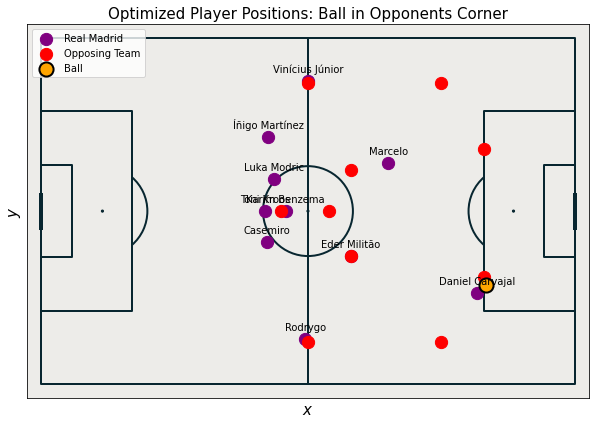

In [133]:
# Define opposing players and their positions (scenario is in the back corner)
opposing_team = ["Opponent " + str(i) for i in range(10)]
opposing_positions = np.array([
    [100, 55], [100, 25],  # Center-backs
    [90, 70], [90, 10],  # Full-backs
    [70, 30], [65, 40], [70, 50],  # Midfielders
    [60, 70], [60, 10],  # Wingers
    [55, 40]  # Striker
])

# Ball position in the back corner for this example
ball_position = np.array([100, 23])


# Define the minimum distance threshold and team weight
min_distance = 5  # Minimum desired distance between players (adjust as needed)
team_weight = 0.5  # Adjust this value between 0 and 1 to balance individual and team probabilities
guard_penalty_weight = 2  # Weight for the guarding position penalty
offside_threshold = 50  # Threshold for pushing the defensive line up

# Objective function to minimize
def objective(x, probability_matrix, player_idx, opposing_positions, ball_position, goal_position):
    # x is a 2-element array with [x_coordinate, y_coordinate]
    x_idx = int(np.clip(x[0], 0, 119))
    y_idx = int(np.clip(x[1], 0, 79))

    # Avoid division by zero by adding a small constant
    probability_penalty = 1 / (probability_matrix[player_idx, x_idx, y_idx] + 1e-10)

    # Initialize clustering penalty
    clustering_penalty = 0

    # Calculate distance between the current player and all other players
    for other_idx, other_position in enumerate(optimized_positions):
        if other_idx != player_idx:
            distance = np.linalg.norm(x - other_position)
            if distance < min_distance:
                clustering_penalty += (min_distance - distance) ** 2

    # Calculate the sum of individual player probabilities
    team_probability = 0
    for i in range(len(Real_Madrid)):
        team_probability += 1 / (probability_matrix[i, int(optimized_positions[i, 0]), int(optimized_positions[i, 1])] + 1e-10)

    # Calculate guard penalty
    guard_penalty = 0
    for opp_idx, opp_position in enumerate(opposing_positions):
        if opp_idx == player_idx:
            distance_to_opp = np.linalg.norm(x - opp_position)
            goal_distance = np.linalg.norm(goal_position - opp_position)
            projected_x = (goal_position[0] - opp_position[0]) * (distance_to_opp / goal_distance) + opp_position[0]
            projected_y = (goal_position[1] - opp_position[1]) * (distance_to_opp / goal_distance) + opp_position[1]
            guard_penalty = np.linalg.norm([projected_x, projected_y] - x) * guard_penalty_weight

    # Offside constraint: push defensive line up if the ball is far up the field
    offside_penalty = 0
    if ball_position[0] > offside_threshold:
        offside_penalty = (x[0] - offside_threshold) ** 2 if x[0] < offside_threshold else 0

    # Combine individual player probability, clustering penalty, guard penalty, and team probability
    objective_value = (1 - team_weight) * probability_penalty + team_weight * team_probability + clustering_penalty + guard_penalty + offside_penalty

    return objective_value

# Optimization function for a single player
def optimize_player(player_idx):
    bounds = [(0, 119), (0, 79)]  # Bounds for x and y coordinates
    result = differential_evolution(objective, bounds, args=(probability_matrix, player_idx, opposing_positions, ball_position, goal_position), strategy='best1bin',
                                    popsize=15, tol=1e-4, mutation=(0.5, 1), recombination=0.7,
                                    seed=42, callback=iteration_callback)
    return result.x

# Define the goal position (center of the goal line)
goal_position = np.array([0, 40])

# Optimize positions for all players
optimized_positions = np.zeros((len(Real_Madrid), 2))
for i, player in enumerate(Real_Madrid):
    optimized_positions[i] = optimize_player(i)
    print(f"Optimized position for {player}: {optimized_positions[i]}")

# Assign the closest Real Madrid player to pressure the ball
closest_player_idx = np.argmin(np.linalg.norm(optimized_positions - ball_position, axis=1))
optimized_positions[closest_player_idx] = ball_position - 2

# Scale optimized positions to fit the 100x100 pitch dimensions
optimized_positions_scaled = np.zeros_like(optimized_positions)
optimized_positions_scaled[:, 0] = optimized_positions[:, 0] * (100 / 120)
optimized_positions_scaled[:, 1] = optimized_positions[:, 1] * (100 / 80)

# Plot the optimized positions and save the figure
fig, ax = pitch.draw(figsize=(10, 6))

# Plot each player's optimized position
for i, player in enumerate(Real_Madrid):
    ax.scatter(optimized_positions_scaled[i][0], optimized_positions_scaled[i][1], color='purple', s=150, label='Real Madrid' if i == 0 else '')
    ax.text(optimized_positions_scaled[i][0], optimized_positions_scaled[i][1] + 2, player, fontsize=10, ha='center', va='bottom')

# Plot opposing players' positions
opposing_positions_scaled = np.zeros_like(opposing_positions)
opposing_positions_scaled[:, 0] = opposing_positions[:, 0] * (100 / 120)
opposing_positions_scaled[:, 1] = opposing_positions[:, 1] * (100 / 80)
for i, opponent in enumerate(opposing_team):
    ax.scatter(opposing_positions_scaled[i][0], opposing_positions_scaled[i][1], color='red', s=150, label='Opposing Team' if i == 0 else '')

# Plot the ball position
ball_position_scaled = ball_position * [100 / 120, 100 / 80]
ax.scatter(ball_position_scaled[0], ball_position_scaled[1], color='orange', s=200, label='Ball', edgecolors='black', linewidths=2)

# Add a legend
ax.legend(loc='upper left')

ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)
ax.set_title('Optimized Player Positions: Ball in Opponents Corner', fontsize=15)

# Save the figure
plt.savefig("optimized_positions_with_defensive_constraints.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()